In [0]:
import numpy as np
import matplotlib.pyplot as plt
# Load the Drive helper and mount
from google.colab import drive

In [2]:
# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
'/content/drive/My Drive/speeches.txt'


In [0]:
# softmax of a numpy array
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0) 

In [0]:
# forward pass for one-to-one RNN architecture
def forward_pass(X, Y, h_init, parameters):
    
    # dictionaries to store values at each time step
    h = {} # to keep hidden states
    x = {} # to keep input states
    y = {} # to keep softmax output (array of probs with vocab size)
    
    # retrieve the model parameters
    W_xh,W_hh,W_hy,b_h,b_y = parameters
    
    # set initial hidden state to start RNN loop
    h[-1] = np.copy(h_init) 
    loss = 0
    
    # for each character in the input/output
    for t in range(len(X)):
        
        # one hot representation of character t
        x[t] = np.zeros((vocab_size,1)) 
        x[t][X[t]] = 1
        
        # rnn cell calculations given by formula
        h[t] = np.tanh(np.dot(W_hh,h[t-1]) + np.dot(W_xh,x[t]) + b_h)
        y[t] = softmax(np.dot(W_hy,h[t]) + b_y)
        
        # get the softmax probability of output character t
        softmax_out = y[t][Y[t],0]
        
        # update the cross entropy (softmax) loss at each time step
        loss += -np.log(softmax_out)
        
    return loss, y, x, h, h[len(X)-1] # rnn input and hidden states are needed for backward pass
    

In [0]:
def backward_pass(X, Y, parameters,y,x,h):
        
    # retrieve model parameters
    W_xh,W_hh,W_hy,b_h,b_y = parameters
    
    # initialize the gradients of same shape with parameters
    dW_xh,dW_hh,dW_hy,db_h,db_y = np.zeros(W_xh.shape),np.zeros(W_hh.shape),np.zeros(W_hy.shape),np.zeros(b_h.shape),np.zeros(b_y.shape)
    dh_next = np.zeros(h[0].shape)
    
    # backpropagation for each time step
    for t in reversed(range(len(X))):
        
        # calculate gradients for all parameters 
        d_y = np.copy(y[t])
        d_y[Y[t]] = d_y[Y[t]] - 1
        dW_hy += np.dot(d_y,h[t].T)
        db_y += d_y
        d_h = np.dot(W_hy.T, d_y) + dh_next
        d_tanh = (1- h[t]*h[t]) *d_h # derivative of tanh (1-t2)dt
        db_h += d_tanh 
        dW_xh += np.dot(d_tanh, x[t].T)
        dW_hh += np.dot(d_tanh, h[t-1].T)
        dh_next = np.dot(W_hh.T,d_tanh)
        
    return (dW_xh,dW_hh,dW_hy,db_h,db_y)

In [0]:
def SGD(X, Y, h_init, parameters, learning_rate):
    
    loss, y_preds, x, h, h_init = forward_pass(X,Y,h_init,parameters)
    gradients = backward_pass(X,Y,parameters,y_preds,x,h)
    #gradients = gradient_clip(gradients)
    
    new_params = []
    for i in range(len(parameters)):
        new_params.append(parameters[i] - learning_rate * gradients[i] )
    return tuple(new_params), h_init, loss

In [0]:
def initialize_parameters(num_hiddens,vocab_size):

    # weight matrices
    W_hx = np.random.randn(num_hiddens, vocab_size) * 0.01
    W_hh = np.random.randn(num_hiddens, num_hiddens) * 0.01
    W_yh = np.random.randn(vocab_size, num_hiddens) * 0.01
    
    # biases
    b_h = np.zeros((num_hiddens, 1))
    b_y = np.zeros((vocab_size, 1))
        
    return (W_hx,W_hh,W_yh,b_h,b_y)

In [0]:
def train(data, num_hiddens, vocab_size, batch_size, learning_rate, num_epoch, char_to_index, index_to_char):
    
    num_iteration = int((len(data)/batch_size) * num_epoch) # total number of iteration
    parameters = initialize_parameters(num_hiddens,vocab_size) # get model parameters
    h_init = np.zeros((num_hiddens, 1)) # get initial hidden vector
    smooth_loss = -np.log(1.0/vocab_size)*batch_size # smooth loss not to see high osscilations (credits: Karpathy vanilla RNN)
    
    losses = []
    cnt = 1
    epoch_cnt = 1
    for i in range(num_iteration):
                
        # get batch of training data
        X_batch = []
        Y_batch = []
        for j in range(batch_size):
            X_batch.append(char_to_index[data[cnt-1]])
            Y_batch.append(char_to_index[data[cnt]])
            cnt+=1
            
        # forward/backward pass and update parameters
        parameters, h_init, loss = SGD(X_batch, Y_batch, h_init, parameters, learning_rate)
        smooth_loss = smooth_loss * 0.999 + loss * 0.001
        losses.append(smooth_loss)
            
        # epoch is completed print progress and reset counter
        if (len(data) - cnt) <= batch_size or (i == 0):
            print ("Epoch:", epoch_cnt,"\tBatch:", str(cnt-1) + "/" + str(len(data)), "\tLoss:", smooth_loss)
            cnt = 1
            epoch_cnt+=1
            
    return parameters,h_init,losses

In [0]:
def sampling(parameters, h_init, sample_size, index_to_char):
    
    # retrieve model parameters
    W_xh,W_hh,W_hy,b_h,b_y = parameters
    
    # get the hyper parameters
    vocab_size = b_y.shape[0]
    num_hiddens = W_hh.shape[1]
    
    # initialize the sequence and first hidden state
    x = np.zeros((vocab_size,1))
    #h_init = np.zeros((num_hiddens,1))
    # store all sampled indices
    indices = []
    
    for i in range(sample_size):
        
        # make forward pass
        h_init = np.tanh(np.dot(W_hh,h_init) + np.dot(W_xh,x) + b_h)
        y = softmax(np.dot(W_hy,h_init) + b_y)
        
        # get a random index in vocab within the probability distribution of y (ravel())
        index = np.random.choice(range(vocab_size), p=y.ravel())
        
        # add the sampled char into one hot vector
        x = np.zeros((vocab_size, 1))
        x[index] = 1
        
        # append chosen index at each iteration
        indices.append(index)
    
    sampled_text = ''
    for index in indices:
        sampled_text += index_to_char[index]
    
    return sampled_text

In [0]:
def data_preprocess(file_path):
    data = open(file_path, 'r',encoding = 'utf-8').read()
    data = data.lower()
    data = ''.join([i for i in data if not i.isdigit()])
    data = (data.translate({ord(i): None for i in '][&=%)-@\ufeff;_é$('})) 
    char_set = list(set(data))
    vocab_size = len(char_set)
    data_size = len(data)
    char_to_index = { ch:i for i,ch in enumerate(char_set) } # to index each char in data
    index_to_char = { i:ch for i,ch in enumerate(char_set) } # to print generated char index
    
    return data, vocab_size, char_to_index,index_to_char

# Trump Speech

In [0]:
data, vocab_size, char_to_index, index_to_char = data_preprocess("/content/drive/My Drive/speeches.txt")

In [0]:
# hyperparameters (chosen by experiments)
num_hiddens = 150
batch_size = 100
learning_rate = 0.001
num_epoch = 12

In [13]:
parameters, h_init, loss_history = train(data,num_hiddens, vocab_size, batch_size, learning_rate, num_epoch, char_to_index, index_to_char)

Epoch: 1 	Batch: 100/891479 	Loss: 376.1199891113728
Epoch: 2 	Batch: 891400/891479 	Loss: 198.5989692792207
Epoch: 3 	Batch: 891400/891479 	Loss: 170.3894478995746
Epoch: 4 	Batch: 891400/891479 	Loss: 157.60121457779493
Epoch: 5 	Batch: 891400/891479 	Loss: 150.44044000065216
Epoch: 6 	Batch: 891400/891479 	Loss: 145.9852464188745
Epoch: 7 	Batch: 891400/891479 	Loss: 142.9700438330822
Epoch: 8 	Batch: 891400/891479 	Loss: 140.81607290079847
Epoch: 9 	Batch: 891400/891479 	Loss: 139.1327426461128
Epoch: 10 	Batch: 891400/891479 	Loss: 137.84397843322512
Epoch: 11 	Batch: 891400/891479 	Loss: 136.83862173950166
Epoch: 12 	Batch: 891400/891479 	Loss: 135.84353882700896
Epoch: 13 	Batch: 891400/891479 	Loss: 134.9228162700672


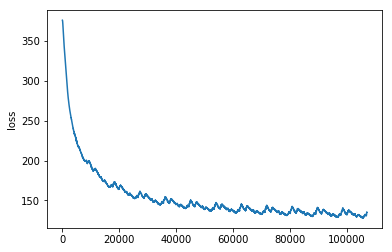

In [14]:
import matplotlib.pyplot as plt
plt.plot(loss_history)
plt.ylabel('loss')
plt.show()

In [15]:
print("Generated text: ",sampling(parameters, h_init, 1000, index_to_char))

Generated text:  . we have great for somethrust hape. and i have a creatia.
whor time for it would we're go to believe than shoull country. it justll so says write trade teal midgration jobs a fir, jeffs in of the best perestre. so the cwing now isal. not's in a gheap us of very michlies masten on ghist te spote in tomal of it, a trump.

or is talk her. our has politics ire pubying richast is. i seen jobly an of the hightate vely tileas is up? they will beaity that coucty ware uffiou.
so that to bumppriat? but he negertor it will heve  in it was till them. so she ampisiciate for in indere of how more worod hillary being breatess. i love, with it this idn's a guy we're going he commion'l. it's unangrgoc would son the way.  it want the pence – you would who will be americe – wo'll has been proctive well. she digntt did took intrrear nems. and for a stappedy exaids that won'this bacer chantrips a big eners for the world back that if it's done to mexte' it our the way intay these that coun

# Shakespeare Sonnets

In [0]:
data, vocab_size, char_to_index, index_to_char = data_preprocess("/content/drive/My Drive/sonnets.txt")

In [0]:
# hyperparameters (chosen by experiments)
num_hiddens = 75
batch_size = 50
learning_rate = 0.001
num_epoch = 40

In [30]:
parameters, h_init, loss_history = train(data,num_hiddens, vocab_size, batch_size, learning_rate, num_epoch, char_to_index, index_to_char)

Epoch: 1 	Batch: 50/96141 	Loss: 177.76740676292425
Epoch: 2 	Batch: 96100/96141 	Loss: 152.87332345994457
Epoch: 3 	Batch: 96100/96141 	Loss: 133.48517373835352
Epoch: 4 	Batch: 96100/96141 	Loss: 122.98104313356272
Epoch: 5 	Batch: 96100/96141 	Loss: 117.2566426211953
Epoch: 6 	Batch: 96100/96141 	Loss: 112.97279295517684
Epoch: 7 	Batch: 96100/96141 	Loss: 109.52457368012955
Epoch: 8 	Batch: 96100/96141 	Loss: 106.63987367592102
Epoch: 9 	Batch: 96100/96141 	Loss: 104.12809151900247
Epoch: 10 	Batch: 96100/96141 	Loss: 101.93276277396208
Epoch: 11 	Batch: 96100/96141 	Loss: 99.99024230016366
Epoch: 12 	Batch: 96100/96141 	Loss: 98.30579146634021
Epoch: 13 	Batch: 96100/96141 	Loss: 96.85819599826198
Epoch: 14 	Batch: 96100/96141 	Loss: 95.60277932213847
Epoch: 15 	Batch: 96100/96141 	Loss: 94.4982531963851
Epoch: 16 	Batch: 96100/96141 	Loss: 93.51305087532857
Epoch: 17 	Batch: 96100/96141 	Loss: 92.62718008772738
Epoch: 18 	Batch: 96100/96141 	Loss: 91.82938195606005
Epoch: 19 	Bat

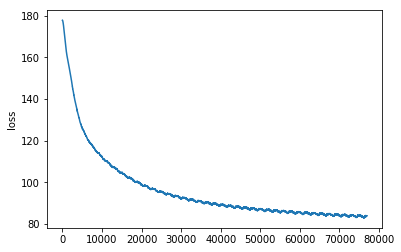

In [31]:
plt.plot(loss_history)
plt.ylabel('loss')
plt.show()

In [32]:
print("Generated text:")
print(sampling(parameters, h_init, 500, index_to_char))

Generated text:
ils
know chald mine eye
that cal the time alose.


whose if that verile i do my that shaus: ill.
thy one'd fyemer.
tin have and my bedvegh with the sub'd privaging flomerst where
from thou the trows and i new liother thou roslive might praies if my own now livest deprace,
no leve enerpur do ith'd' faite the prause, breage?
on the crecount,
who, what the bailing drane to pearifed's soof, the weatire
for preasorn that my seeatume,
the eols the getuld thou west to whill when blace,
by serle the wil
